# Sketches of Hue

## 0. Intro

I've been sitting on this for a bit, and since I find video/phone conferences very difficult to communicate over, I wanted to sketch out a couple of my ideas about gamut-mapping in a scene-referred context and see where they go. This post serves to document that thought process.

Firstly, I really enjoyed many of Daniele's points:
* the breakdown of the gamut-mapping processing stages
* each gamut-mapping stage has different requirements and considerations
* the concept of a "zone of trust"
* The impossibility of prescribing perceptual intent onto scene-referred colour data

Spring-boarding off some of these ideas, in this post I want to explore the scene-referred post-IDT pre-Rendering gamut mapping space (Stage 1), some of the conceptual ideas feeding into it, and and open question about what we should/could be considering in this process.


## 1. The Perturbed Reality

When looking at "Stage 1" gamut mapping, it is quite obvious to note that if the input systems were perfect, there would be no need for gamut mapping into the encoding space at all (AP0). It is only due to the Luther-Ives Criterion failure of most input devices, and consequently the quality of their color corrections (IDT) that produce out-of-spectral-locus data.

In dealing with this situation, I completely agree with Daniele's comment:
> we cannot utilise state of the art human-centric gamut mapping algorithms

Human-centric being the key word. However, I would soften the statement that there is out-right no correlate to hue in the physical world. I believe that there could be a correlate that is more applicable to our scenario, and this "Stage 1" gamut-mapping could potentially look to how cameras interpret this physical attribute in order to better inform our decisions on how to kindly corral these out-of-gamut values safely back home to a zone of "trust".

The concept of camera-interpreted hue, is what I will continue to explore below.

## 1.1 Physical Hue Attribute

The initial exploration of this concept was inspired from flipping through the Wyszecki & Stiles Color Science book, specifically the section 3.7 on "Optimal Object-Color Stimuli" which introduces the concept of the Rösch Color Solid.

In [1]:
import colour
import colour.plotting
from colour.temperature import CCT_to_xy_CIE_D

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000000
import matplotlib.pyplot as plt
mpl.rcParams["figure.figsize"] = (10,10)

import numpy as np

In [2]:

def illum_d_series(cct=6500, l_bound=380, u_bound=780, interval=1):
    _cct_prime = cct * 1.4388 / 1.4380
    _xy = CCT_to_xy_CIE_D(_cct_prime)
    _spd = colour.sd_CIE_illuminant_D_series(_xy).align(colour.SpectralShape(l_bound, u_bound, interval)) / 100.0
    return _spd.normalise().values

def optimal_colour_stimuli(center, width, value=1.0, interval=1, l_bound=380, u_bound=780, illum=None):
    
    assert(len(center) == len(width))
    
    domain = np.arange(l_bound, u_bound + interval, interval)
    _domain = np.tile(domain, (len(center), 1))
    
    _center = np.tile(center, (len(domain), 1)).T
    _width = np.tile(width, (len(domain), 1)).T
    
    _ = center - width
    
    _reflct = np.where(
        np.logical_and(
            _domain >= (_center - _width),
            _domain <= (_center + _width)
        ),
        value,
        0
    )
    
    _under = (_center - _width) - l_bound
    _over = u_bound - (_center + _width)
    
    if np.any(_under < 0):
        _reflct = np.where(_domain >= u_bound + _under, value, _reflct)
    if np.any(_over < 0):
        _reflct = np.where(_domain <= l_bound - _over, value, _reflct)
        
    if illum:
        
        d_illum = illum_d_series(cct=illum)
        d_illum = np.tile(d_illum, (len(center), 1))
        
        _reflct = _reflct * d_illum
        
    _string = "Optimal Colour Stimuli"
    return colour.MultiSpectralDistribution(dict(zip(domain, _reflct.T)), name=_string)


The Rösch Color Solid is a representation of the outer-gamut of reflective colors. Where the spectral reflectance function is either 100% or 0% reflective, centered about a particular wavelength with a specified band-width. For example:

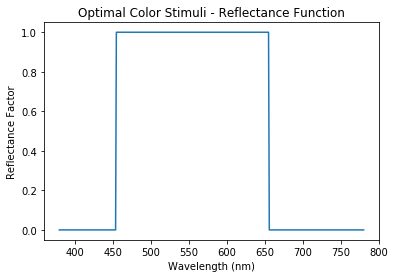

In [3]:
CENTER_WAVELENGTH = 555
BANDWIDTH = 100

ocs = optimal_colour_stimuli(np.array([CENTER_WAVELENGTH]), np.array([BANDWIDTH]))

plt.plot(ocs.to_sds()[0].wavelengths, ocs.to_sds()[0].values)
plt.title("Optimal Color Stimuli - Reflectance Function")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance Factor")
plt.show()

When all iterations of central wavelengths and bandwidths are calculated, their CIE xyY chromaticity values end up forming the outer hull of the Rösch Color Solid:

In [4]:
def optimal_stimuli_hue_line_xy(
    center,
    illum=None,
    cmfs=colour.STANDARD_OBSERVERS_CMFS['CIE 1931 2 Degree Standard Observer'],
    idt=np.eye(3),
    wb=np.ones(3),
    plot=True):
    
    _widths = np.arange(2, 202, 2)
    _center = np.repeat(center, len(_widths))
    
    _msd = optimal_colour_stimuli(_center, _widths, illum=illum)

    _XYZ = [colour.sd_to_XYZ(_spd, cmfs=cmfs) for _spd in _msd.to_sds()]
    _XYZ = _XYZ * wb
    
    
    if not np.array_equal(idt, np.eye(3)):
        
        _XYZ = np.dot(idt, _XYZ.T)
    
        ACES_to_XYZ = np.array(
            [
                [0.9525523959, 0.0, 0.0000936786],
                [0.3439664498, 0.7281660966, -0.0721325464],
                [0.0, 0.0, 1.0088251844],
            ]
        )
        
        _XYZ = np.dot(ACES_to_XYZ, _XYZ).T

    _xyY = colour.XYZ_to_xyY(_XYZ)
    
    if plot:
        plt.plot(_xyY[:, 0], _xyY[:, 1], c='k')
           
    return _xyY
    

In [47]:
import plotly
import plotly.graph_objects as go
from scipy.interpolate import griddata

def plot_rosch_solid():
    _rosch_surface_list = []

    for i in np.arange(380, 790, 5):
        _rosch_surface_list.append(optimal_stimuli_hue_line_xy(i, plot=False))

    _rosch_surface = np.array(_rosch_surface_list).reshape(-1, 3)

    grid_x, grid_y = np.mgrid[0:1:500j, 0:1:500j]

    grid_z = griddata(
        _rosch_surface[:, 0:2],
        _rosch_surface[:, 2],
        (grid_x, grid_y),
        method='linear'
    )

    fig = go.Figure(data=[go.Surface(x=grid_x, y=grid_y, z=grid_z)])

    fig.update_layout(
        title='Rösch Color Solid',
        autosize=False,
        width=600, 
        height=600,
        scene = dict(
            xaxis = dict(title = "x"),
            yaxis = dict(title = "y"),
            zaxis = dict(title = "Y"),
            camera = dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0.0, y=0, z=0),
                eye=dict(x=-1.25, y=-1.5, z=0.75),
            )
        ),
    )

    plotly.offline.plot(fig, "plot.html")
    fig.show()
    
plot_rosch_solid()

In [51]:
# from IPython.display import IFrame

# IFrame(src='./temp-plot.html', width=800, height=600)

While the Rösch solid is interesting in its own right, the concept of the outer reflective hull was quite interesting to me, in particular when investigating the behaviour of camera spectral sensitivities and IDTs. My previous exploration that I shared at IBC 2019 was the initial investigation of the outer "spectral hull" of camera "gamuts" in the xy chromaticity plane, but I was immediately curious about the behaviour within the hull.

Particularly important to me, and to the potential application of gamut-mapping is constant hue lines, which the nature of the reflectance functions used to create the Rösch Solid seem perfectly adept to describe. Here "hue lines" are based around a very simple concept of increasing the bandwidth of a perfectly reflecting surface about a central dominant wavelength, or one "slice" of the Rösch Solid.

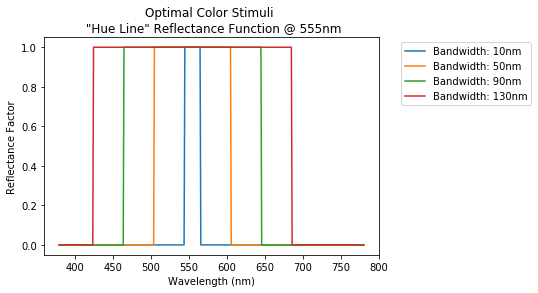

In [31]:
CENTER_WAVELENGTH = 555
BANDWIDTH = np.arange(10, 140, 40)

ocs = optimal_colour_stimuli(
    np.repeat(CENTER_WAVELENGTH, len(BANDWIDTH)),
    BANDWIDTH,
)

for idx, sds in enumerate(ocs.to_sds()):
    plt.plot(
        sds.wavelengths,
        sds.values,
        label="Bandwidth: {0}nm".format(BANDWIDTH[idx])
    )

plt.title('Optimal Color Stimuli \n "Hue Line" Reflectance Function @ 555nm')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Extended to the entire spectral locus, these "hue lines" end up looking something like this for the 1931 2 Degree Standard Observer:

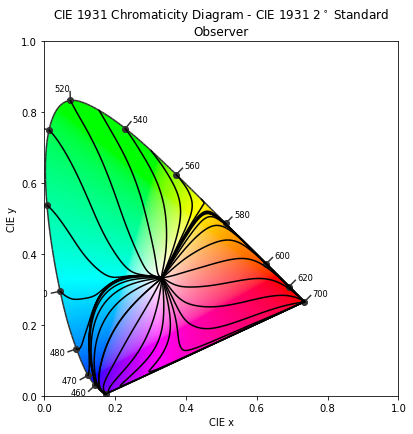

In [9]:
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

for i in np.arange(380, 790, 10):
    optimal_stimuli_hue_line_xy(i)
    
plt.show()

While this certainly appears to be a rather naive interpretation of constant hue lines, there is some research to suggest that this could be reflected in human vision and fairly accurately predict the Abney Effect:

1. Y. Mizokami, J. S. Werner, M. A. Crognale, and M. A. Webster, “Nonlinearities in color coding: Compensating color appearance for the eyes spectral sensitivity,” Journal of Vision, vol. 6, no. 9, p. 12, 2006.

2. S. F. O’Neil, K. C. Mcdermott, Y. Mizokami, J. S. Werner, M. A. Crognale, and M. A. Webster, “Tests of a functional account of the Abney effect,” Journal of the Optical Society of America A, vol. 29, no. 2, 2012.

3. H. Mirzaei and B. Funt, “Gaussian-Based Hue Descriptors,” IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 37, no. 12, pp. 2441–2450, Jan. 2015.

Bearing in mind the Rösch slice method uses rect functions instead of a Gaussian distributions, the potential perceptual relevancy of this physical "hue line" definition is quite alluring. In particular, it is made much more practical and useful due to the fact that it is has a very clear and obvious physical meaning.

## 1.2 I'm A Camera, Not a Man

Naturally the next step was to see how a camera might interpret this Rösch Solid, and what it's "hue lines" could look like.

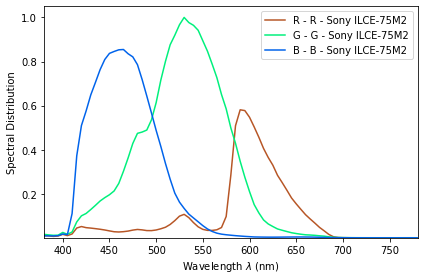

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f45142bcd90>)

In [10]:
# Data taken from the rawtoaces Academy project:
# https://github.com/ampas/rawtoaces/blob/master/data/camera/sony_ilce-7rm2_380_780_5.json

SONY_7RII_DATA = {
    "380": [ 0.01070351, 0.01611734, 0.00910183],
    "385": [ 0.00886833, 0.01364172, 0.00947460],
    "390": [ 0.00685820, 0.01178321, 0.00892802],
    "395": [ 0.00846579, 0.01236838, 0.01019366],
    "400": [ 0.01628673, 0.02480968, 0.01768990],
    "405": [ 0.01045624, 0.01614185, 0.01538890],
    "410": [ 0.01789739, 0.02683030, 0.11043681],
    "415": [ 0.04484923, 0.07256666, 0.37269335],
    "420": [ 0.05151796, 0.10012634, 0.50951706],
    "425": [ 0.04652330, 0.11079298, 0.57558231],
    "430": [ 0.04446170, 0.12865022, 0.64852249],
    "435": [ 0.04196042, 0.14760037, 0.70521708],
    "440": [ 0.03922729, 0.16737607, 0.76317928],
    "445": [ 0.03585121, 0.18254057, 0.80913460],
    "450": [ 0.03178538, 0.19572474, 0.83688555],
    "455": [ 0.02795772, 0.21291812, 0.84558172],
    "460": [ 0.02681043, 0.24719273, 0.85310141],
    "465": [ 0.02827173, 0.30221094, 0.85452737],
    "470": [ 0.03094595, 0.36280875, 0.83517165],
    "475": [ 0.03535963, 0.42822675, 0.82117943],
    "480": [ 0.03832960, 0.47421299, 0.78580632],
    "485": [ 0.03640184, 0.48006435, 0.71831941],
    "490": [ 0.03322971, 0.48918541, 0.64356572],
    "495": [ 0.03302307, 0.53545183, 0.56659300],
    "500": [ 0.03587511, 0.61320216, 0.48795868],
    "505": [ 0.04135572, 0.71529251, 0.41519451],
    "510": [ 0.04831954, 0.80090488, 0.33757566],
    "515": [ 0.06091324, 0.87586950, 0.26653211],
    "520": [ 0.07838501, 0.91926583, 0.20301553],
    "525": [ 0.09868409, 0.96669546, 0.16223559],
    "530": [ 0.10682711, 1.00000000, 0.13374059],
    "535": [ 0.09192618, 0.97678369, 0.10794860],
    "540": [ 0.06933520, 0.96415485, 0.09044720],
    "545": [ 0.05023869, 0.94184354, 0.07312016],
    "550": [ 0.03870151, 0.89412467, 0.05559411],
    "555": [ 0.03419018, 0.84655008, 0.04051650],
    "560": [ 0.03398562, 0.78828314, 0.02927539],
    "565": [ 0.03675054, 0.72748795, 0.02152791],
    "570": [ 0.04708229, 0.65046676, 0.01700286],
    "575": [ 0.09710697, 0.58544640, 0.01427649],
    "580": [ 0.28485692, 0.49886599, 0.01216295],
    "585": [ 0.50884081, 0.42904845, 0.01017439],
    "590": [ 0.58100779, 0.34768186, 0.00847781],
    "595": [ 0.57748231, 0.27529281, 0.00689261],
    "600": [ 0.54727549, 0.21015235, 0.00563390],
    "605": [ 0.50322970, 0.15102961, 0.00431546],
    "610": [ 0.45652775, 0.11336795, 0.00391012],
    "615": [ 0.40606458, 0.08159473, 0.00359147],
    "620": [ 0.36504823, 0.06336822, 0.00339128],
    "625": [ 0.32969356, 0.05155727, 0.00333714],
    "630": [ 0.28387621, 0.04056255, 0.00343332],
    "635": [ 0.25078219, 0.03460037, 0.00361563],
    "640": [ 0.21647652, 0.02893097, 0.00384625],
    "645": [ 0.18111594, 0.02339429, 0.00398698],
    "650": [ 0.15444322, 0.01977684, 0.00407162],
    "655": [ 0.12961261, 0.01664676, 0.00414197],
    "660": [ 0.10534670, 0.01410772, 0.00401454],
    "665": [ 0.08573089, 0.01301446, 0.00388416],
    "670": [ 0.06704597, 0.01163754, 0.00344196],
    "675": [ 0.04759109, 0.00953770, 0.00288596],
    "680": [ 0.03192372, 0.00786636, 0.00226519],
    "685": [ 0.01558039, 0.00490161, 0.00155166],
    "690": [ 0.00496982, 0.00257145, 0.00112635],
    "695": [ 0.00196042, 0.00169359, 0.00093835],
    "700": [ 0.00120276, 0.00134926, 0.00079060],
    "705": [ 0.00091482, 0.00116751, 0.00069673],
    "710": [ 0.00073109, 0.00098878, 0.00063956],
    "715": [ 0.00063774, 0.00091075, 0.00058505],
    "720": [ 0.00059039, 0.00082032, 0.00053879],
    "725": [ 0.00054769, 0.00076712, 0.00050753],
    "730": [ 0.00051495, 0.00073913, 0.00048249],
    "735": [ 0.00050084, 0.00070755, 0.00048409],
    "740": [ 0.00048918, 0.00070484, 0.00048003],
    "745": [ 0.00046995, 0.00069348, 0.00046648],
    "750": [ 0.00049356, 0.00070189, 0.00046838],
    "755": [ 0.00048731, 0.00070851, 0.00047506],
    "760": [ 0.00050678, 0.00072214, 0.00049404],
    "765": [ 0.00051616, 0.00073966, 0.00050749],
    "770": [ 0.00053160, 0.00075440, 0.00051652],
    "775": [ 0.00063459, 0.00077987, 0.00052774],
    "780": [ 0.00057194, 0.00075760, 0.00046434]
}

SONY_7RII_SS = colour.MultiSpectralDistribution(
    SONY_7RII_DATA,
    name="Sony ILCE-75M2",
    labels=["R", "G", "B"]
)

colour.plotting.plot_multi_sds(SONY_7RII_SS, use_sds_colours=True)

<Figure size 432x288 with 0 Axes>

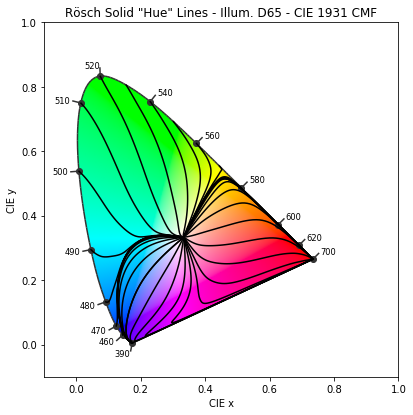

<Figure size 432x288 with 0 Axes>

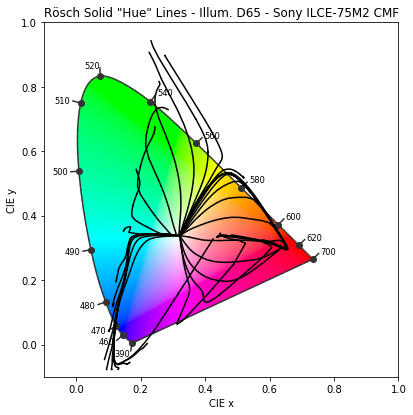

In [26]:
# IDT and WB factors generated by rawtoaces

R2A_IDT_D65 = np.array(
    [
        [0.831984, 0.149368, 0.018649],
        [0.054522, 1.235131, -0.289653],
        [0.057019, -0.249320, 1.192301],
    ]
)

R2A_WB_D65 = np.array([2.988332, 1.0000, 1.323537])

###

plt.figure()
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

for i in np.arange(380, 790, 10):
    optimal_stimuli_hue_line_xy(i)

plt.xlim(-0.1, 1.0)
plt.ylim(-0.1, 1.0)
plt.title('Rösch Solid "Hue" Lines - Illum. D65 - CIE 1931 CMF')
plt.show()

###

plt.figure()
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

for c in range(400, 750, 10):
    optimal_stimuli_hue_line_xy(
        c,
        illum=6500,
        cmfs=SONY_7RII_SS,
        idt=R2A_IDT_D65,
        wb=R2A_WB_D65,
        plot=True
    )

plt.xlim(-0.1, 1.0)
plt.ylim(-0.1, 1.0)
plt.title('Rösch Solid "Hue" Lines - Illum. D65 - Sony ILCE-75M2 CMF')
plt.show()

The figure above represents the how the Sony ILCE-75M2 camera would see/interpret the "hue lines" of the Rosch Solid, and shows the extreme distortions introduced by both a combination of the native non-Luther-Ives spectral sensitivities and the IDT method used.

While it is very clear that the Rosch Solid is outside the realm of normal occurrence in the physical world, and we would need to think of a more plausible outer reflective hull, I believe that it is still could be valuable to explore the outer limits of plausibility. Especially since it is around this realm of spectral sharpness that the errors we've seen in the ACES system are introduced.

Irrespective of the IDT method used (which to this point has been manufacturer defined), I believe that there could potentially be merit to handling gamut-mapping in this stage of the image chain with respect to how a particular camera + IDT combination handles "Hue". Again, returning to the idea that vast majority of these extra-Spectral-Locus values are introduced by a particular camera input, should we not try to maintain the general characteristics of the manufacturers spectral sensitivity + IDT correction in the process of gamut-mapping?

For me it is an open question. For example, if there were out-of-spectral-locus values introduced by a camera system, should we map those values along the natural "hue lines" that that particular camera would have seen if if the stimuli was less spectrally "pure", pulling them into the target gamut along these "hue" trajectories? Rather than ignoring the source of these colorimetric errors and handling them in an input-agnostic human-perceptual or purely-physical manner? I think it could be an interesting concept to explore.

I think that this concept of mapping could also be indifferent to the quality of the IDT used, i.e. how well the IDT reprojects correct chromaticity coordinates. While any improvements to the quality of the IDT would be welcome, since it would reduce the total volume of values that need to be mapped and improve the overall colorimetric "zone of trust", there is still guaranteed to be some "Hue" behaviour unique to that camera + IDT process.

## 2. Closing Remarks

While this is *certainly* a premature evaluation, and I'm not naive to the fact that this concept would need a lot more work to properly explore its validity, I wanted to get this together relatively quickly so I could share my train of thought on the subject before wasting too much time...

This particular exploration is focused on "Stage 1" gamut-mapping, and how we could potentially use the characters tics of the devices introducing colorimetric errors to inform our gamut-mapping solutions. Preserving certain aspects of color gamut unique to these devices when there is no "correct" colorimetric interpretation of the extra-spectral-locus values they introduce to the system.
